In [11]:
import json
from pathlib import Path

def load_all_results(logs_dir='../logs'):
    results = []
    logs_path = Path(logs_dir)
    
    # Check if logs directory exists
    if not logs_path.exists():
        print(f"Warning: Directory '{logs_dir}' not found.")
        return results
    
    # Find all result.json files recursively
    result_files = list(logs_path.rglob('result.json'))
    
    if not result_files:
        print(f"No result.json files found in {logs_dir}")
        return results
    
    # Load each result file
    for result_file in result_files:
        try:
            with open(result_file, 'r') as f:
                data = json.load(f)
                results.append(data)
                print(f"Loaded: {result_file}")
        except json.JSONDecodeError:
            print(f"Error: Could not parse JSON from {result_file}")
        except Exception as e:
            print(f"Error reading {result_file}: {str(e)}")
    
    print(f"\nSuccessfully loaded {len(results)} result files.")
    return results

all_results = load_all_results()


Loaded: ../logs/2025-07-14_12-14-31_openai_o4-mini_anthropic_claude-4-sonnet-20250522_game/result.json
Loaded: ../logs/2025-07-09_21-53-00_Randy_openai_o4-mini_game/result.json
Loaded: ../logs/2025-07-09_20-46-24_openai_o4-mini_Randy_game/result.json
Loaded: ../logs/2025-07-06_07-55-42_openai_o3_Alice_game/result.json
Loaded: ../logs/2025-07-11_10-19-41_Randy_anthropic_claude-4-sonnet-20250522_game/result.json
Loaded: ../logs/2025-07-09_21-08-02_anthropic_claude-4-sonnet-20250522_google_gemini-2.5-pro_game/result.json
Loaded: ../logs/2025-08-02_12-21-55_google_gemini-2.5-pro_openai_o3_game/result.json
Loaded: ../logs/2025-07-11_10-19-41_Randy_openai_o3_game/result.json
Loaded: ../logs/2025-07-14_12-14-31_openai_o3_openai_o4-mini_game/result.json
Loaded: ../logs/2025-07-09_20-46-24_Randy_anthropic_claude-4-sonnet-20250522_game/result.json
Loaded: ../logs/2025-07-11_10-19-41_Randy_google_gemini-2.5-pro_game/result.json
Loaded: ../logs/2025-07-23_07-28-49_google_gemini-2.5-pro_openai_o3_g

In [12]:
def merge_random_players(result):
    players = []
    for p in result["players"]:
        if p['name'] == 'Alice' or p['name'] == 'Bob':
            players.append('Randy')
        else:
            players.append(p['name'])
      
    winner  = result["winner"]
    if winner == 'Alice' or winner == 'Bob':
        winner = 'Randy'
    
    return players, winner


In [13]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

def matchup_grid(matches):
    """
    matches: iterable of (player1, player2) pairs/lists.
    Returns a symmetric pandas DataFrame counting games between players.
    """
    # Normalize each pair so order doesn't matter
    norm_pairs = []
    for a, b in matches:
        if a == b:
            # ignore self-play entries; drop or handle differently if you need counts
            continue
        pair = tuple(sorted((a, b)))
        norm_pairs.append(pair)
    
    counts = Counter(norm_pairs)
    
    # All unique players
    players = sorted({p for pair in counts for p in pair})
    
    # Initialize square DataFrame
    df = pd.DataFrame(0, index=players, columns=players, dtype=int)
    
    # Fill counts symmetrically
    for (a, b), n in counts.items():
        df.at[a, b] = n
        df.at[b, a] = n
    
    return df

def plot_matchup_grid(grid):
    fig, ax = plt.subplots()
    im = ax.imshow(grid.values, aspect='equal')

    # Axis labels
    ax.set_xticks(range(len(grid.columns)))
    ax.set_yticks(range(len(grid.index)))
    ax.set_xticklabels(grid.columns, rotation=45, ha='right')
    ax.set_yticklabels(grid.index)

    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Games played")

    # Annotate each cell
    data = grid.values
    max_val = data.max() if data.size else 0
    thresh = max_val / 2.0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = data[i, j]
            # Choose text color for contrast
            color = "white" if val > thresh else "black"
            ax.text(j, i, str(val), ha='center', va='center', color=color)

    ax.set_title("Player Matchup Counts")
    plt.tight_layout()
    plt.show()

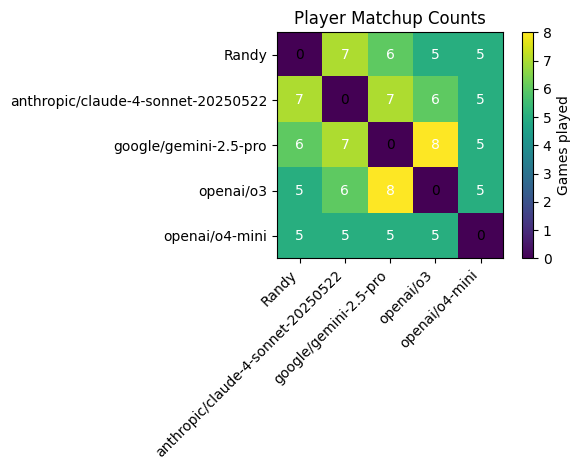

In [14]:
matches = []
for result in all_results:                       
    players, winner = merge_random_players(result)
    matches.append(players)
    
plot_matchup_grid(matchup_grid(matches))

In [15]:
import pandas as pd
from collections import defaultdict
from IPython.display import display

# --- hyper-params ------------------------------------------------------------
K          = 32          # Elo K-factor
START_ELO  = 1000        # initial rating
# -----------------------------------------------------------------------------


# containers for running stats
ratings = defaultdict(lambda: START_ELO)
stats   = defaultdict(lambda: {"wins": 0, "losses": 0, "games": 0})

for result in all_results:                       # iterate every match record
    players, winner = merge_random_players(result)
    loser = next(p for p in players if p != winner)

    # ---- win / loss counts --------------------------------------------------
    stats[winner]["wins"]  += 1
    stats[loser]["losses"] += 1
    stats[winner]["games"] += 1
    stats[loser]["games"]  += 1

    # ---- Elo update ---------------------------------------------------------
    Ra, Rb           = ratings[winner], ratings[loser]
    Ea               = 1 / (1 + 10 ** ((Rb - Ra) / 400))
    ratings[winner] += K * (1 - Ea)          # winner’s new rating
    ratings[loser]  += K * (0 - (1 - Ea))    # loser’s new rating (Eb = 1-Ea)

# ---- assemble DataFrame -----------------------------------------------------
rows = []
for player, s in stats.items():
    wins, losses, games = s["wins"], s["losses"], s["games"]
    rows.append(
        {
            "player"   : player,
            "wins"     : wins,
            "losses"   : losses,
            "games"    : games,
            "win_rate" : wins / games,
            "elo"      : round(ratings[player], 2),
        }
    )

df = (
    pd.DataFrame(rows)
      .sort_values("elo", ascending=False)
      .reset_index(drop=True)
)

# nice display 🪄
display(
    df.style
      .format({"win_rate": "{:.1%}", "elo": "{:.0f}"})
      .background_gradient(axis=0, subset=["elo"])
)


,player,wins,losses,games,win_rate,elo
0,google/gemini-2.5-pro,17,9,26,65.4%,1081
1,openai/o4-mini,14,6,20,70.0%,1066
2,openai/o3,11,13,24,45.8%,975
3,anthropic/claude-4-sonnet-20250522,9,16,25,36.0%,954
4,Randy,8,15,23,34.8%,924
